#  NLP Project : Detecting adversarial attacks

# Preliminaries 

We import our packages.

In [ ]:
!pip install matplotlib
!pip install numpy
!pip install sklearn
!pip install scipy
!pip install tensorflow
!pip install pandas
!pip install datasets
!pip install evaluate
!pip install scienceplots

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [270]:
#general 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

#for models
import tensorflow as tf
!pip install transformers
import transformers as tr
import datasets as dt
!pip install sentence_transformers
import sklearn.model_selection as model_selection
import sklearn.covariance as Covariance
import sklearn.decomposition as Decomposition
from sentence_transformers import SentenceTransformer
from scipy.stats import multivariate_normal
from scipy.linalg import sqrtm
from tqdm.auto import tqdm
import evaluate as ev
from sklearn.metrics import roc_curve,RocCurveDisplay, roc_auc_score, f1_score


#for attacks
#!pip install textattack[tensorflow] 
#from textattack import Attack
#from textattack.constraints.grammaticality import PartOfSpeech
#from textattack.constraints.pre_transformation import (
#    InputColumnModification,
#    RepeatModification,
#    StopwordModification,
#)
#from textattack.constraints.semantics import WordEmbeddingDistance
#from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder
#from textattack.goal_functions import UntargetedClassification
#from textattack.search_methods import GreedyWordSwapWIR
#from textattack.transformations import WordSwapEmbedding
#
#from .attack_recipe import AttackRecipe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


We import our dataset.

In [295]:
imdb_dataset = pd.read_csv("bert-base-uncased-imdb_bae.csv")

# Parametric density estimation

## Robust density estimation method

In [296]:
#The dataset is already quite clean, we simply need to remove bracket in the text : 
imdb_sentences = imdb_dataset["original_text"].apply(lambda x : x.replace("[","").replace("]",""))

#Let"s get the embedding : 
BERT_transformer = SentenceTransformer('textattack/bert-base-uncased-imdb')

IMDB_embeddings = BERT_transformer.encode(imdb_sentences)

No sentence-transformers model found with name /home/onyxia/.cache/torch/sentence_transformers/textattack_bert-base-uncased-imdb. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/onyxia/.cache/torch/sentence_transformers/textattack_bert-base-uncased-imdb were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**kernel PCA**

In [316]:
#Instantiate and use Kernel PCA : 
PCA_kernel = Decomposition.KernelPCA(n_components = 100, kernel = "rbf")
embeddings_PCA = PCA_kernel.fit_transform(IMDB_embeddings)

#interlude : separation of class 0 and 1 : 
class_1_IMDB = embeddings_PCA[imdb_dataset["ground_truth_output"] == 1]
class_0_IMDB = embeddings_PCA[imdb_dataset["ground_truth_output"] == 0]
#Now the MLE estimation after PCA : 
MLE_mean1 = np.sum(class_1_IMDB, axis=0)/np.shape(class_0_IMDB)[0]
MLE_mean0 = np.sum(class_0_IMDB, axis=0)/np.shape(class_0_IMDB)[0]

#For covariance we make a loop :
MLE_cov1 = np.zeros((MLE_mean1.shape[0],MLE_mean1.shape[0])) 
MLE_cov0 = np.zeros((MLE_mean0.shape[0],MLE_mean0.shape[0])) 
for line in class_1_IMDB : 
    MLE_cov1 = MLE_cov1 + np.reshape(line,(line.shape[0],1))@np.reshape(line,(1,line.shape[0]))

for line in class_0_IMDB : 
    MLE_cov0 = MLE_cov0 + np.reshape(line,(line.shape[0],1))@np.reshape(line,(1,line.shape[0]))

**Minimum Covariance Determinant**

In [298]:
#Now we can add the MCD :
MCD_cov1 = Covariance.MinCovDet()
MCD_cov1.fit(embeddings_PCA[imdb_dataset["ground_truth_output"] == 1])

RDE_mean1 = MCD_cov1.location_
RDE_cov1 = MCD_cov1.covariance_

MCD_cov0 = Covariance.MinCovDet()
MCD_cov0.fit(embeddings_PCA[imdb_dataset["ground_truth_output"] == 0])

RDE_mean0 = MCD_cov0.location_
RDE_cov0 = MCD_cov0.covariance_

---
### Some visualisations

Now some visualisation for these freshly estimated density : 

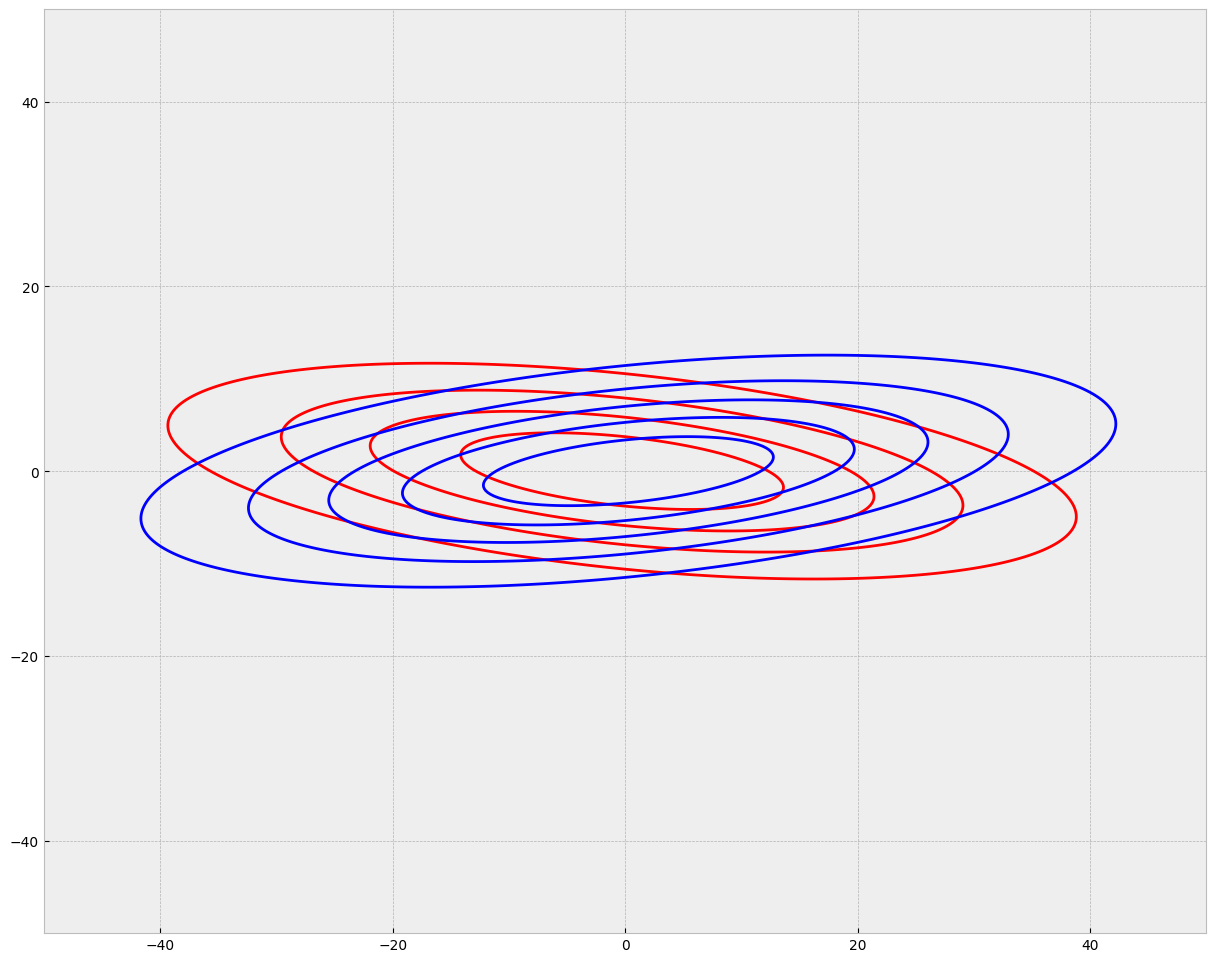

In [375]:
#Let's try to visualise the distribution, with the MLE : 

#To have the value of 2d multivariate at different point (made to be used with np.meshgrid) 
normal_density_1 = multivariate_normal(MLE_mean1[0:2], MLE_cov1[0:2,0:2])
normal_density_0 = multivariate_normal(MLE_mean0[0:2], MLE_cov0[0:2,0:2])

plt.style.use('bmh')
fig,ax = plt.subplots(figsize = (15, 12))

abscisse, ordonnee = np.meshgrid(np.linspace(-100, 100, 1000), np.linspace(-100, 100, 1000))
level = np.dstack((abscisse, ordonnee))

ax.contour(abscisse, ordonnee, normal_density_1.pdf(level), 20, levels = 5, colors = "red")
ax.contour(abscisse, ordonnee, normal_density_0.pdf(level), 20, levels = 5, colors = "blue")

ax.set_xlim((-50,50))
ax.set_ylim((-50,50))

plt.savefig("Normal_multivariate_distribution_MLE")

plt.show()

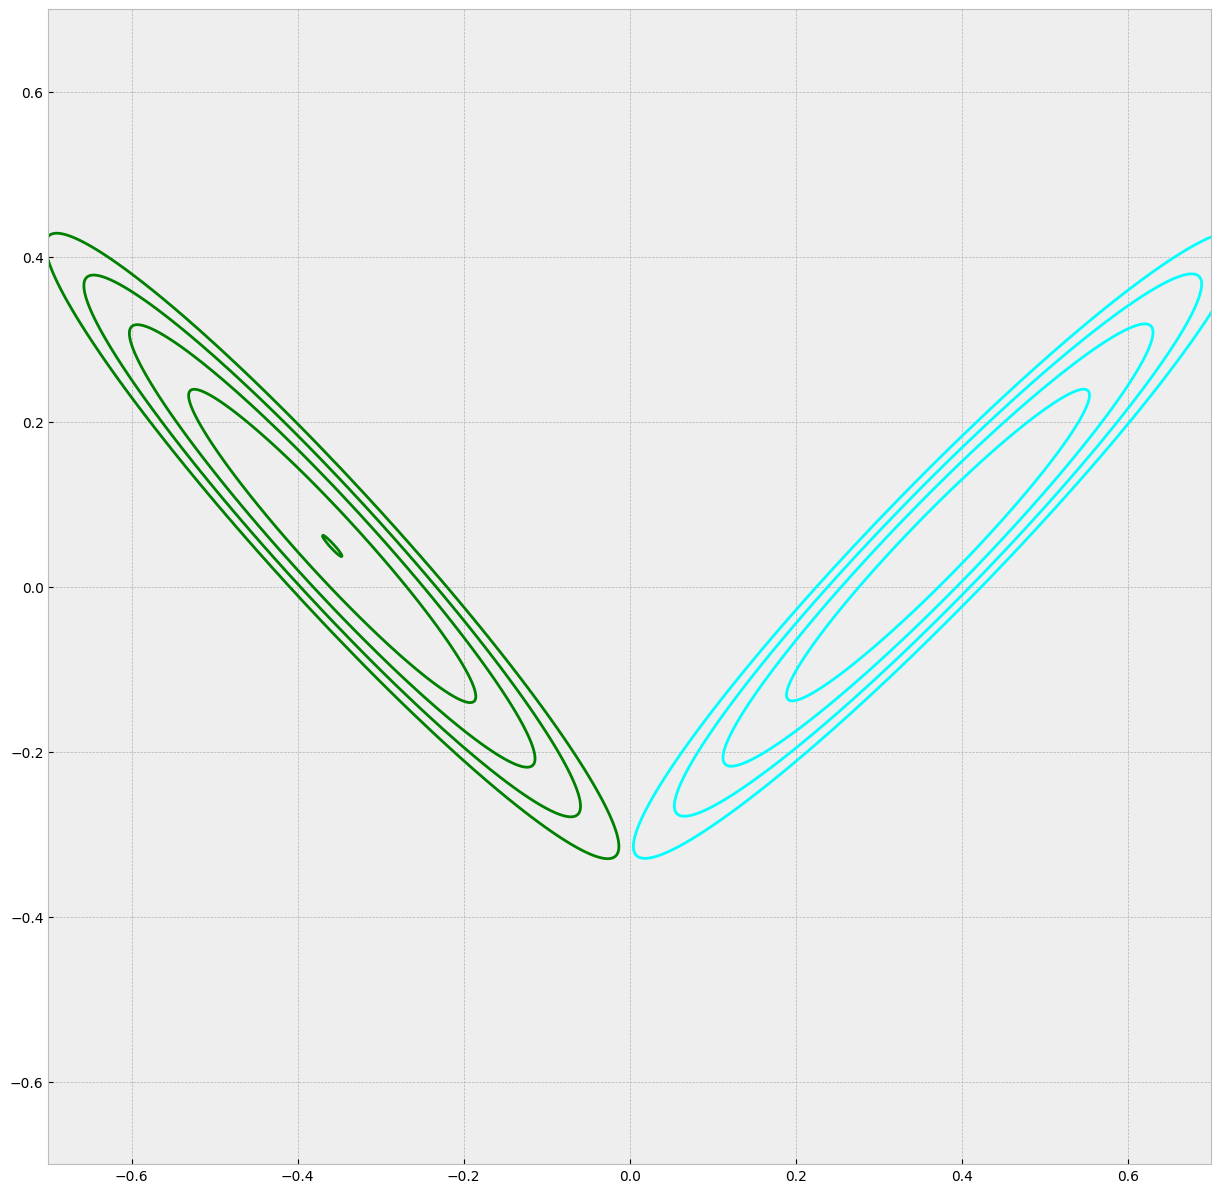

In [371]:
#Let's try to visualise the distribution, with the RDE : 

#To have the value of 2d multivariate at different point (made to be used with np.meshgrid) 
normal_density_1 = multivariate_normal(RDE_mean1[0:2], RDE_cov1[0:2,0:2])
normal_density_0 = multivariate_normal(RDE_mean0[0:2], RDE_cov0[0:2,0:2])

plt.style.use('bmh')
fig,ax = plt.subplots(figsize = (15, 15))

abscisse, ordonnee = np.meshgrid(np.linspace(-1, 1, 1000), np.linspace(-1, 1, 1000))
level = np.dstack((abscisse, ordonnee))

ax.contour(abscisse, ordonnee, normal_density_1.pdf(level), 20, levels = np.logspace(-3, 2, 5), colors = "green")
ax.contour(abscisse, ordonnee, normal_density_0.pdf(level), 20, levels = np.logspace(-3, 2, 5), colors = "cyan")

ax.set_xlim((-0.7,0.7))
ax.set_ylim((-0.7,0.7))

plt.savefig("Normal_multivariate_distribution_RDE")

plt.show()

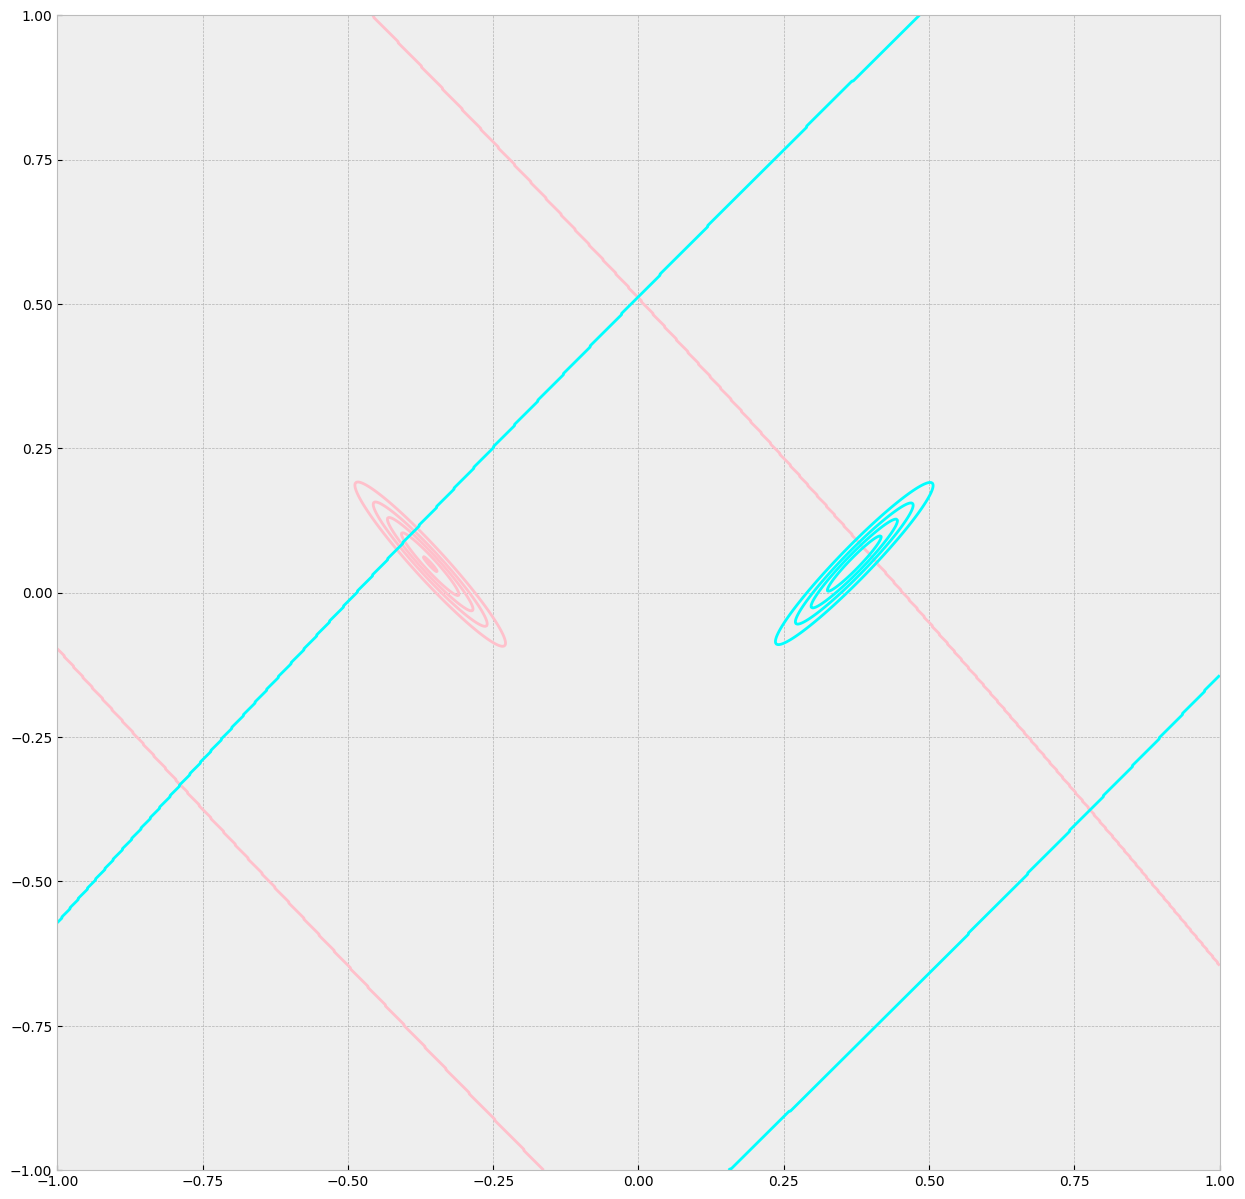

In [321]:
#Let's try to visualise the distribution, with the MLE : 

#To have the value of 2d multivariate at different point (made to be used with np.meshgrid) 
normal_density_1 = multivariate_normal(MLE_mean1[0:2], MLE_cov1[0:2,0:2])
normal_density_0 = multivariate_normal(MLE_mean0[0:2], MLE_cov0[0:2,0:2])

plt.style.use('bmh')
fig,ax = plt.subplots(figsize = (15, 15))

abscisse, ordonnee = np.meshgrid(np.linspace(-100, 100, 1000), np.linspace(-100, 100, 1000))
level = np.dstack((abscisse, ordonnee))

ax.contour(abscisse, ordonnee, normal_density_1.pdf(level), 20, levels = 5, colors = "red")
ax.contour(abscisse, ordonnee, normal_density_0.pdf(level), 20, levels = 5, colors = "blue")

normal_density_1 = multivariate_normal(RDE_mean1[0:2], RDE_cov1[0:2,0:2])
normal_density_0 = multivariate_normal(RDE_mean0[0:2], RDE_cov0[0:2,0:2])

abscisse, ordonnee = np.meshgrid(np.linspace(-1, 1, 1000), np.linspace(-1, 1, 1000))
level = np.dstack((abscisse, ordonnee))

ax.contour(abscisse, ordonnee, normal_density_1.pdf(level), 20, levels = 5, colors = "pink")
ax.contour(abscisse, ordonnee, normal_density_0.pdf(level), 20, levels = 5, colors = "cyan")

ax.set_xlim((-1,1))
ax.set_ylim((-1,1))

plt.savefig("Normal_multivariate_distribution_MLE_and_RDE")

plt.show()

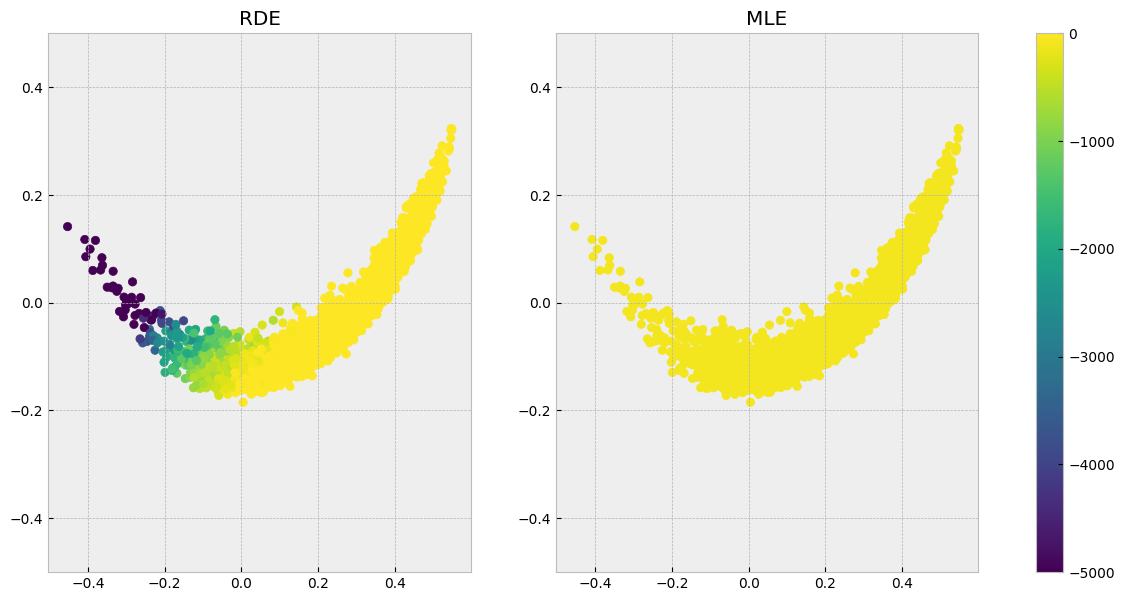

In [376]:
#Let's try to visualise the value of the density for different point, with the MLE : 

#To have the value of 2d multivariate at different point :
normal_density_RDE = multivariate_normal(RDE_mean0, RDE_cov0)
normal_density_MLE = multivariate_normal(RDE_mean0, MLE_cov0)

fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (15, 7))

first_scatter = ax1.scatter(class_0_IMDB[:,0], class_0_IMDB[:,1], c = normal_density_RDE.logpdf(class_0_IMDB), vmin=-5000, vmax=0)

ax1.set_ylim((-0.5,0.5))
ax1.set_title("RDE")

normal_density_0 = multivariate_normal(MLE_mean0, MLE_cov0)

second_scatter = ax2.scatter(class_0_IMDB[:,0], class_0_IMDB[:,1], c = normal_density_MLE.logpdf(class_0_IMDB), vmin=-5000, vmax=0)

ax2.set_ylim((-0.5,0.5))
ax2.set_title("MLE")

fig.colorbar(second_scatter, ax=[ax1,ax2])

plt.savefig("Comparison between MLE and RDE")

plt.show()

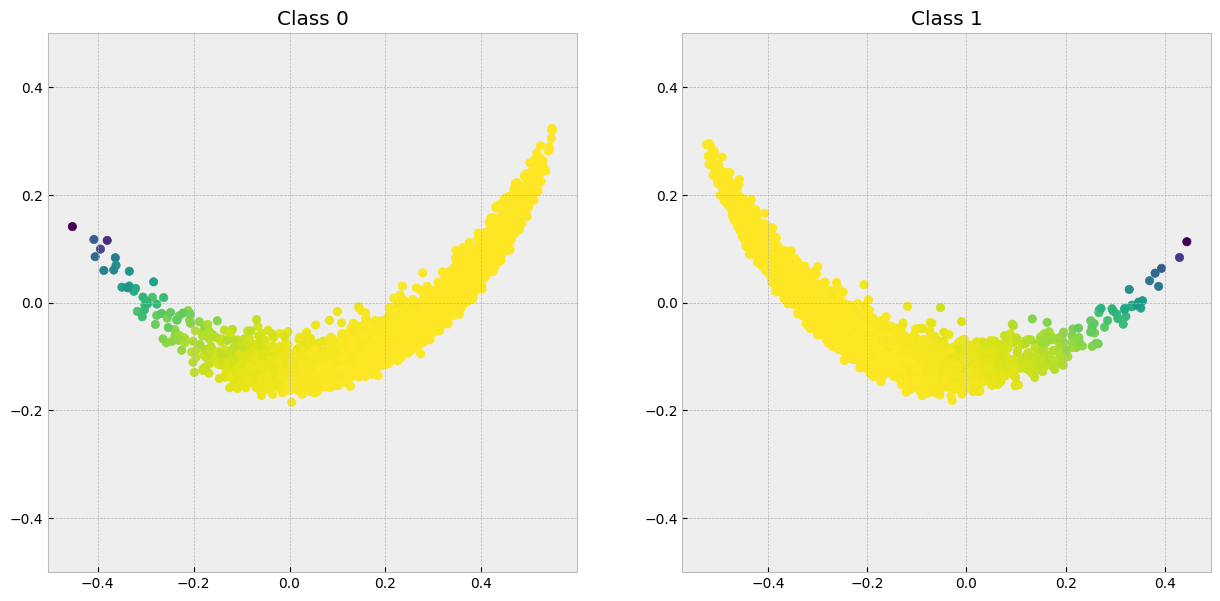

In [301]:
#Let's try to visualise the value of the density for different point, with the MLE : 

#To have the value of 2d multivariate at different point :
normal_density_0 = multivariate_normal(RDE_mean0, RDE_cov0)
normal_density_1 = multivariate_normal(RDE_mean1, RDE_cov1)

fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (15, 7))

ax1.scatter(class_0_IMDB[:,0], class_0_IMDB[:,1], c = normal_density_0.logpdf(class_0_IMDB))

ax1.set_ylim((-0.5,0.5))
ax1.set_title("Class 0")

normal_density_0 = multivariate_normal(MLE_mean0, MLE_cov0)

ax2.scatter(class_1_IMDB[:,0], class_1_IMDB[:,1], c = normal_density_1.logpdf(class_1_IMDB))

ax2.set_ylim((-0.5,0.5))
ax2.set_title("Class 1")

plt.savefig("Comparison of class 0 and 1 for non perturbed text")

plt.show()

In [302]:
#Now with the adversarial examples : 

imdb_sentences = imdb_dataset["perturbed_text"].apply(lambda x : x.replace("[","").replace("]",""))

#Let"s get the embedding : 
perturbed_IMDB_embeddings = BERT_transformer.encode(imdb_sentences)

[-83.376128   -83.36791047 -83.36388994 ... -83.38404898 -83.3843304
 -83.36685226]


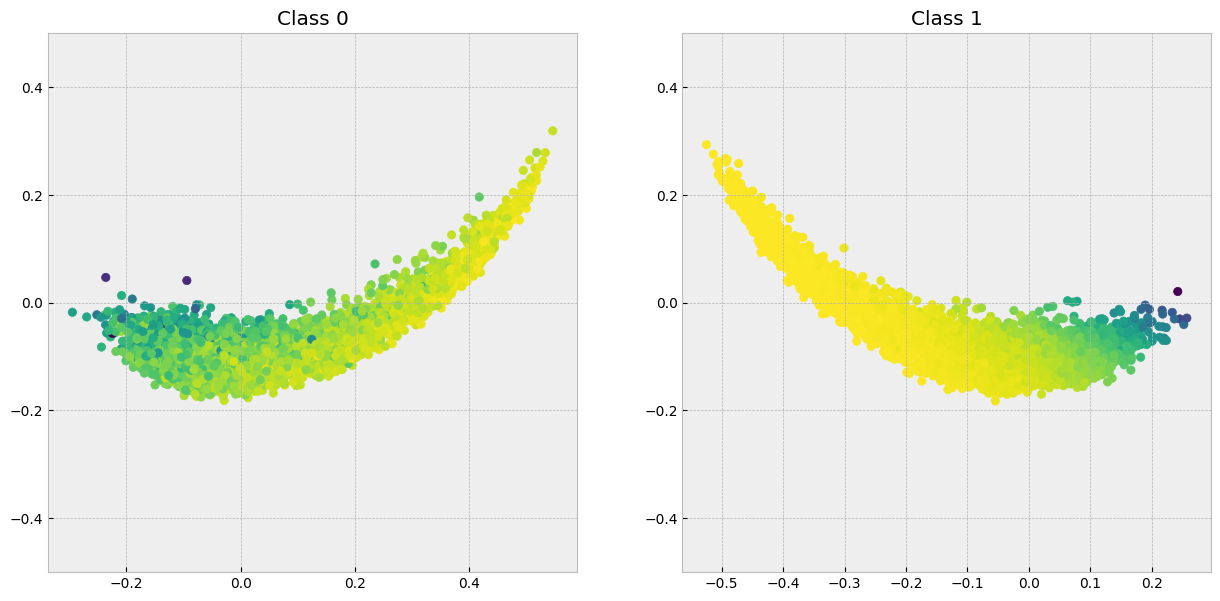

In [303]:
perturbed_0 = PCA_kernel.transform(perturbed_IMDB_embeddings[imdb_dataset["perturbed_output"] == 0])
perturbed_1 = PCA_kernel.transform(perturbed_IMDB_embeddings[imdb_dataset["perturbed_output"] == 1])

#To have the value of 2d multivariate at different point :

fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (15, 7))

ax1.scatter(perturbed_0[:,0], perturbed_0[:,1], c = normal_density_0.logpdf(perturbed_0[:]))

print(np.log(normal_density_0.pdf(perturbed_0)))

ax1.set_ylim((-0.5,0.5))
ax1.set_title("Class 0")

normal_density_1 = multivariate_normal(RDE_mean1, RDE_cov1)

ax2.scatter(perturbed_1[:,0], perturbed_1[:,1], c = normal_density_1.logpdf(perturbed_1[:]))

ax2.set_ylim((-0.5,0.5))
ax2.set_title("Class 1")

plt.savefig("Comparison of class 0 and 1 for perturbed text")

plt.show()

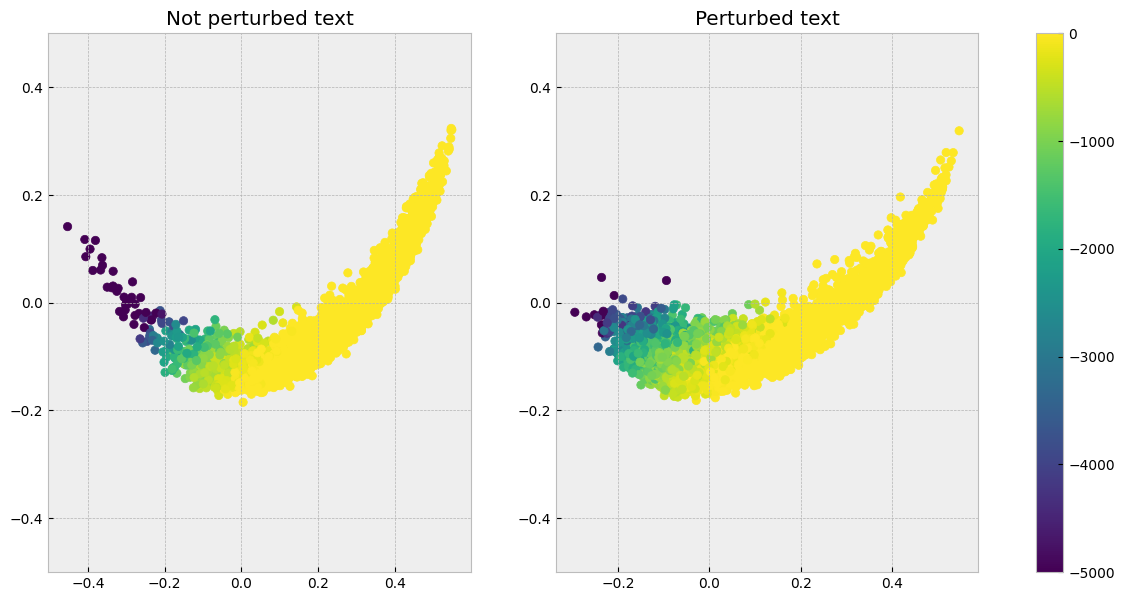

In [356]:
#To have the value of 2d multivariate at different point :
normal_density_0 = multivariate_normal(RDE_mean0, RDE_cov0)
normal_density_1 = multivariate_normal(RDE_mean1, RDE_cov1)

fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (15, 7))

first_scatter = ax1.scatter(class_0_IMDB[:,0], class_0_IMDB[:,1], c = normal_density_0.logpdf(class_0_IMDB), vmin=-5000, vmax=0)

ax1.set_ylim((-0.5,0.5))
ax1.set_title("Not perturbed text")

normal_density_1 = multivariate_normal(RDE_mean1, RDE_cov1)

second_scatter = ax2.scatter(perturbed_0[:,0], perturbed_0[:,1], c = normal_density_0.logpdf(perturbed_0[:]), vmin=-5000, vmax=0)

ax2.set_ylim((-0.5,0.5))
ax2.set_title("Perturbed text")

fig.colorbar(second_scatter, ax=[ax1,ax2])

plt.savefig("Comparison between perturbed and non perturbed text_RDE")

plt.show()

[-83.376128   -83.36791047 -83.36388994 ... -83.38404898 -83.3843304
 -83.36685226]


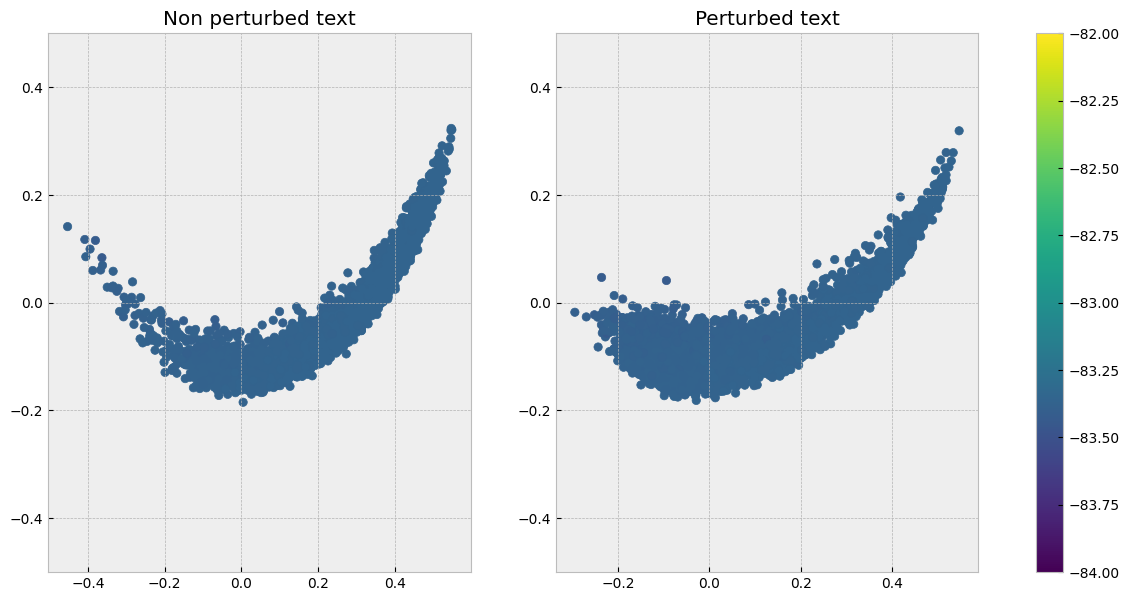

In [369]:
#To have the value of 2d multivariate at different point :
normal_density_0 = multivariate_normal(MLE_mean0, MLE_cov0)
normal_density_1 = multivariate_normal(MLE_mean1, MLE_cov1)

fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (15, 7))

ax1.scatter(class_0_IMDB[:,0], class_0_IMDB[:,1], c = normal_density_0.logpdf(class_0_IMDB), vmin = -84, vmax = -82)

print(np.log(normal_density_0.pdf(perturbed_0)))

ax1.set_ylim((-0.5,0.5))
ax1.set_title("Non perturbed text")

normal_density_1 = multivariate_normal(RDE_mean1, RDE_cov1)

second_scatter = ax2.scatter(perturbed_0[:,0], perturbed_0[:,1], c = normal_density_0.logpdf(perturbed_0[:]),  vmin = -84, vmax = -82)

ax2.set_ylim((-0.5,0.5))
ax2.set_title("Perturbed text")

fig.colorbar(second_scatter, ax=[ax1,ax2])

plt.savefig("Comparison between perturbed and non perturbed text_MLE")

plt.show()

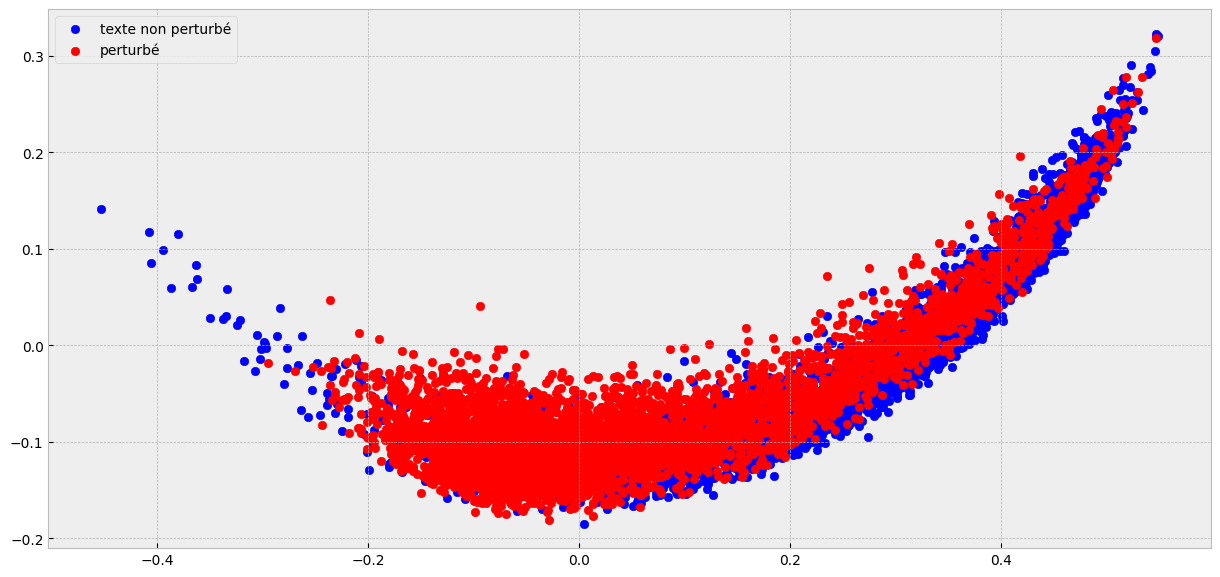

In [336]:
#To have the value of 2d multivariate at different point :
normal_density_0 = multivariate_normal(RDE_mean0, RDE_cov0)
normal_density_1 = multivariate_normal(RDE_mean1, RDE_cov1)

fig,ax = plt.subplots(figsize = (15, 7))

ax.scatter(class_0_IMDB[:,0], class_0_IMDB[:,1], c = "blue", label = "texte non perturbé")

ax.scatter(perturbed_0[:,0], perturbed_0[:,1], c = "red", label = "perturbé")

ax.legend()

plt.savefig("Comparison of distribution for perturbed and unpertubed text")

plt.show()

In [304]:
def full_model_evaluation(dataset, text_col, label_col) :
    text_train, text_test, label_train, label_test = sklearn.model_selection.train_test_split(dataset[text_col], dataset[label_col], test_size=0.33, random_state=42)

def get_dataset(dataset_name, model, attack_name):
    filename = model + '-' + dataset_name + "_" + attack_name + ".csv"
    dataframe = pd.read_csv(filename)
    return dataframe

def text_cleaner(text):
    return text.replace("[","").replace("]","")

def make_train_test(dataset_name, model, attack_name, number_attack_sample = 1000):
    dataset = get_dataset(dataset_name, model, attack_name)
    #keep only the columns that will be useful, ie "original text", "perturbed text" and "ground_truth_output"
    dataset = dataset[["original_text", "perturbed_text", "ground_truth_output", "result_type"]]
    
    #clean the text columns : 
    dataset["original_text"] = dataset["original_text"].map(text_cleaner)
    dataset["perturbed_text"] = dataset["perturbed_text"].map(text_cleaner)
    
    #Now shuffle the dataset with a full sampling without replacement such that any order would be destroyed : 
    dataset = dataset.sample(frac=1).reset_index(drop = True)
    
    #we will keep "number_attack_sample" adversarial example :
    adversarial_sample = dataset.loc[:number_attack_sample-1].reset_index(drop = True)
    normal_sample = dataset.loc[number_attack_sample:].reset_index(drop = True)
    
    #we will retain only the adversarial samples that were successful : 
    adversarial_sample = adversarial_sample.loc[adversarial_sample["result_type"] == "Successful"]
    #in adversarial sample we simply need the text : 
    adversarial_sample = adversarial_sample.drop(["original_text","ground_truth_output", "result_type"], axis = 1)
    
    #for non adversarial we need to separate one time more : one part will be for training and another one for testing.
    #We will keep for testing as much normal example as we have adversarial examples : 
    normal_test_sample = normal_sample.loc[:number_attack_sample-1].reset_index(drop = True)
    train_sample = normal_sample.loc[number_attack_sample:].reset_index(drop = True)
    
    normal_test_sample = normal_test_sample.drop(["perturbed_text","ground_truth_output", "result_type"], axis = 1)
    train_sample = train_sample.drop(["perturbed_text", "result_type"], axis = 1)
    
    train_sample.columns = ["text","label"]
        
    #now fuse the test set, with a new "label" column that will contain if it's an attack or not : 
    adversarial_sample.columns = ["text"]
    normal_test_sample.columns = ["text"]
    
    test_sample = pd.concat([adversarial_sample, normal_test_sample], axis = 0)
    test_sample["label"] = np.concatenate([np.ones(adversarial_sample.shape[0]),np.zeros(number_attack_sample)], axis = 0)
    
    #shuffle : 
    test_sample = test_sample.sample(frac=1).reset_index(drop = True)
    
    return {"train" : train_sample, "test": test_sample}

def get_embeddings(model, data):
    embedder = SentenceTransformer(model)
    
    #if dict, return a dict of embeddings with same keys : 
    if isinstance(data, dict):
        embeddings_dict = {}
        for key in data.keys() : 
            embeddings_dict[key] = embedder.encode(data[key]["text"])
        return embeddings_dict
    
    #if not, a dataframe is expected and only the embeddings: 
    else :
        embeddings = embedder.encode(data["text"])
        return embeddings

def gaussian_logdens(mean,cov):
    inv_cov = np.linalg.inv(cov)
    def dens(x):
        centered_x = x-mean
        return np.dot(np.dot(centered_x, inv_cov),centered_x)
    return dens

def make_detector(train_embeddings, train_label, estimation_type = "MLE", kernel = "rbf", calculated_density = "cond"):
    progress_bar = tqdm(range(1,3) , desc = f"Progression :")
    progress_bar.set_postfix({'Etape en cours' : 'PCA'})
    #PCA : 
    #Instantiate and use Kernel PCA : 
    PCA_kernel = Decomposition.KernelPCA(n_components = 100, kernel = kernel)
    embeddings_PCA = PCA_kernel.fit_transform(train_embeddings)

    #separation of class and then estimation : 
    #dict to keep the different double index label and mean / cov :
    class_estim = {}
    progress_bar.update(1)
    progress_bar.set_postfix({'Etape en cours' : 'Estimation'})
    for label in pd.unique(train_label):
        class_estim[label] = {}
        
        #keep only homogeneous in term of label data :
        mask_class = train_label == label
        class_homogenous_data = embeddings_PCA[mask_class]
        
        #Now the MLE estimation after PCA : 
        if estimation_type == "RDE" :
            #MCD estimation with scikit learn : 
            MCD_cov = Covariance.MinCovDet()
            MCD_cov.fit(class_homogenous_data)

            class_estim[label]["mean"] = MCD_cov.location_
            class_estim[label]["covariance"] = MCD_cov.covariance_
            
        else :
            #mean estimation
            class_estim[label]["mean"] = np.sum(class_homogenous_data, axis=0)/np.shape(class_homogenous_data)[0]
            
            #covariance estimation : shape class_estim[label]["mean"].shape[0] x class_estim[label]["mean"].shape[0]
            #then loop over lines :
            cov_shape = (class_estim[label]["mean"].shape[0],class_estim[label]["mean"].shape[0])
            class_estim[label]["covariance"] = np.zeros(cov_shape)
            for line in class_homogenous_data : 
                class_estim[label]["covariance"] += np.reshape(line,(line.shape[0],1))@np.reshape(line,(1,line.shape[0]))
    
        #We have all the matrix and mean needed, let's calculate the density : 
        class_estim[label]['density'] = gaussian_logdens(class_estim[label]["mean"], class_estim[label]["covariance"])
        if calculated_density == "join" :
            class_estim[label]['prevalence'] = np.sum(mask_class)/embeddings_PCA.shape[0]
            
    progress_bar.update(1)
    progress_bar.set_postfix({'Etape en cours' : 'Création fonction finale'})
    #Now that we have all that, we can def the model that take as entry text and output classification :
    def attack_detector(embedded_text):
        #make PCA on the embeddings : 
        reduced_embeddings = PCA_kernel.transform(embedded_text)
        if calculated_density == "join" : 
            density = np.zeros(reduced_embeddings.shape[0])
            threshold = 0
            for label in pd.unique(train_label):
                density += class_estim[label]['prevalence']*class_estim[label]['density'](reduced_embeddings)
            return list(density)
        else :
            result = []
            dic_classification = {"density":[],"label":[]}
            for lines in reduced_embeddings:
                prec_dens = 0
                for label in pd.unique(train_label):
                    new_dens = class_estim[label]['density'](lines)
                    if new_dens > prec_dens :
                        prec_dens = new_dens
                        max_label = label
                dic_classification["density"].append(prec_dens)
                dic_classification["label"].append(max_label)
            return dic_classification["density"]
    
    progress_bar.update(1)
    progress_bar.set_postfix({'Etape en cours' : 'Fin'})
    return attack_detector

def return_metrics(result, label, fpr_threshold):
    false_pos_r, true_pos_r, threshold = roc_curve(label, result)
    auc = roc_auc_score(label, result)
    
    #for f1-score we will need to have a label-list : 
    #First get the mask : 
    mask_threshold = (false_pos_r <= fpr_threshold)
    
    #Then the maximum true positive rate for this threshold :
    tpr_at_fpr = np.max(true_pos_r * mask_threshold)
    
    #the cutoff we need for prediction : 
    roc_cutoff = np.sort(np.unique(mask_threshold*fpr_threshold))[1]
    
    #prediction with this cutoff:
    pred = [score > roc_cutoff for score in result]
    
    f1 = f1_score(label, pred)
    
    return {"auc" : auc, "f1" : f1, "tpr" : tpr_at_fpr}


In [261]:
dict_train_test = make_train_test("imdb", "bert-base-uncased", "bae", number_attack_sample = 1000)
embeddings = get_embeddings("textattack/bert-base-uncased-imdb", dict_train_test)

No sentence-transformers model found with name /home/onyxia/.cache/torch/sentence_transformers/textattack_bert-base-uncased-imdb. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/onyxia/.cache/torch/sentence_transformers/textattack_bert-base-uncased-imdb were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progression ::   0%|          | 0/2 [00:00<?, ?it/s]

Score avec l'attaque bae de la méthode MLE {'auc': 0.729787979966611, 'f1': 0.21968365553602812, 'tpr': 0.325}


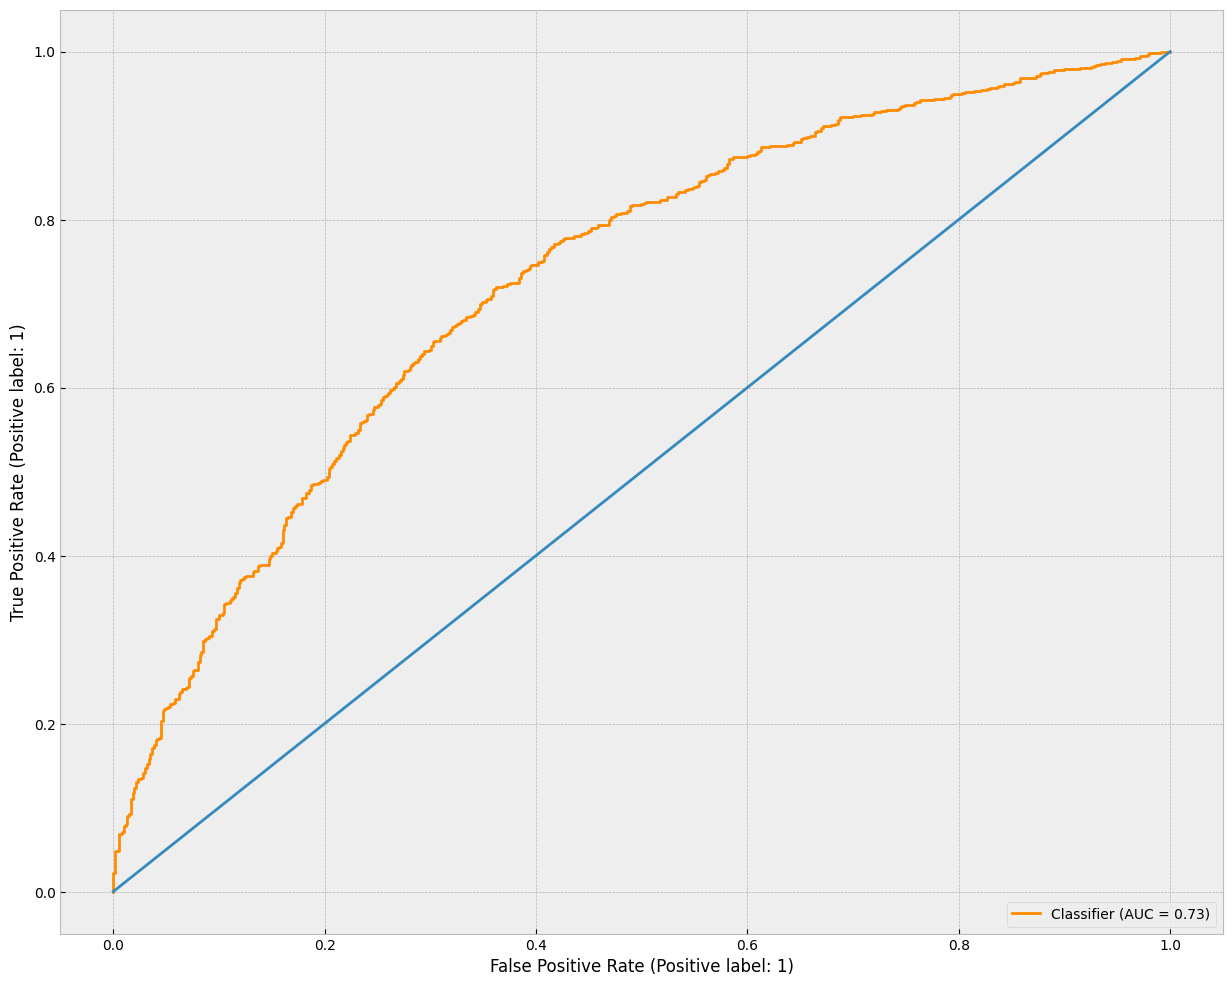

In [279]:
MLEdetector_bae = make_detector(embeddings['train'], dict_train_test["train"]["label"], estimation_type = "MLE", kernel = "rbf")
MLEresult_bae = MLEdetector_bae(embeddings['test'])

MLEscore_bae = return_metrics(MLEresult_bae, 1 - dict_train_test["test"]["label"], 0.1)

print(f"Score avec l'attaque bae de la méthode MLE {MLEscore_bae}")

plt.style.use('bmh')
fig,ax = plt.subplots(figsize = (15, 12))

RocCurveDisplay.from_predictions(
    1 - dict_train_test["test"]["label"],
    MLEresult_bae,
    color="darkorange",
    ax = ax
)
ax.plot(np.linspace(0,1,10),np.linspace(0,1,10))
plt.show()

Progression ::   0%|          | 0/2 [00:00<?, ?it/s]

Score avec l'attaque bae de la méthode MLE {'auc': 0.9089315525876461, 'f1': 0.7695267410542517, 'tpr': 0.81}


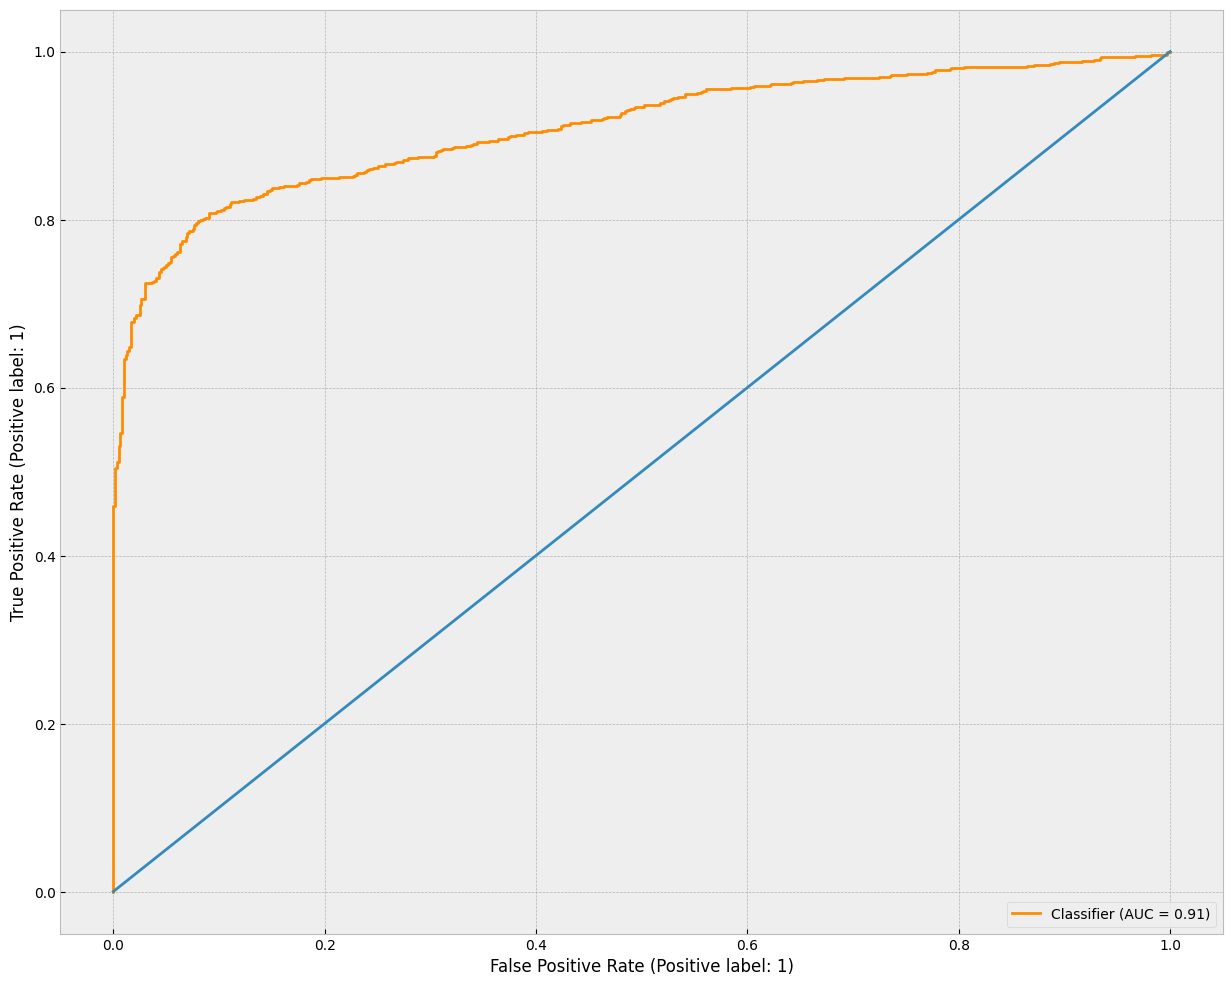

In [278]:
RDEdetector_bae = make_detector(embeddings['train'], dict_train_test["train"]["label"], estimation_type = "RDE", kernel = "rbf")
RDEresult_bae = RDEdetector_bae(embeddings['test'])

RDEscore_bae = return_metrics(RDEresult_bae, 1 - dict_train_test["test"]["label"], 0.1)

print(f"Score avec l'attaque bae de la méthode RDE {RDEscore_bae}")

fig,ax = plt.subplots(figsize = (15, 12))

RocCurveDisplay.from_predictions(
    1 - dict_train_test["test"]["label"],
    RDEresult_bae,
    color="darkorange",
    ax = ax
)
ax.plot(np.linspace(0,1,10),np.linspace(0,1,10))

plt.show()
different_attack = ["bae", "pruthi", "pwws", "textfooler", "tf-adj"]

In [280]:
dict_train_test = make_train_test("imdb", "bert-base-uncased", "pruthi", number_attack_sample = 1000)
embeddings = get_embeddings("textattack/bert-base-uncased-imdb", dict_train_test)

No sentence-transformers model found with name /home/onyxia/.cache/torch/sentence_transformers/textattack_bert-base-uncased-imdb. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/onyxia/.cache/torch/sentence_transformers/textattack_bert-base-uncased-imdb were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progression ::   0%|          | 0/2 [00:00<?, ?it/s]

Score avec l'attaque pruthi de la méthode MLE {'auc': 0.6905314285714285, 'f1': 0.9195402298850576, 'tpr': 0.267}


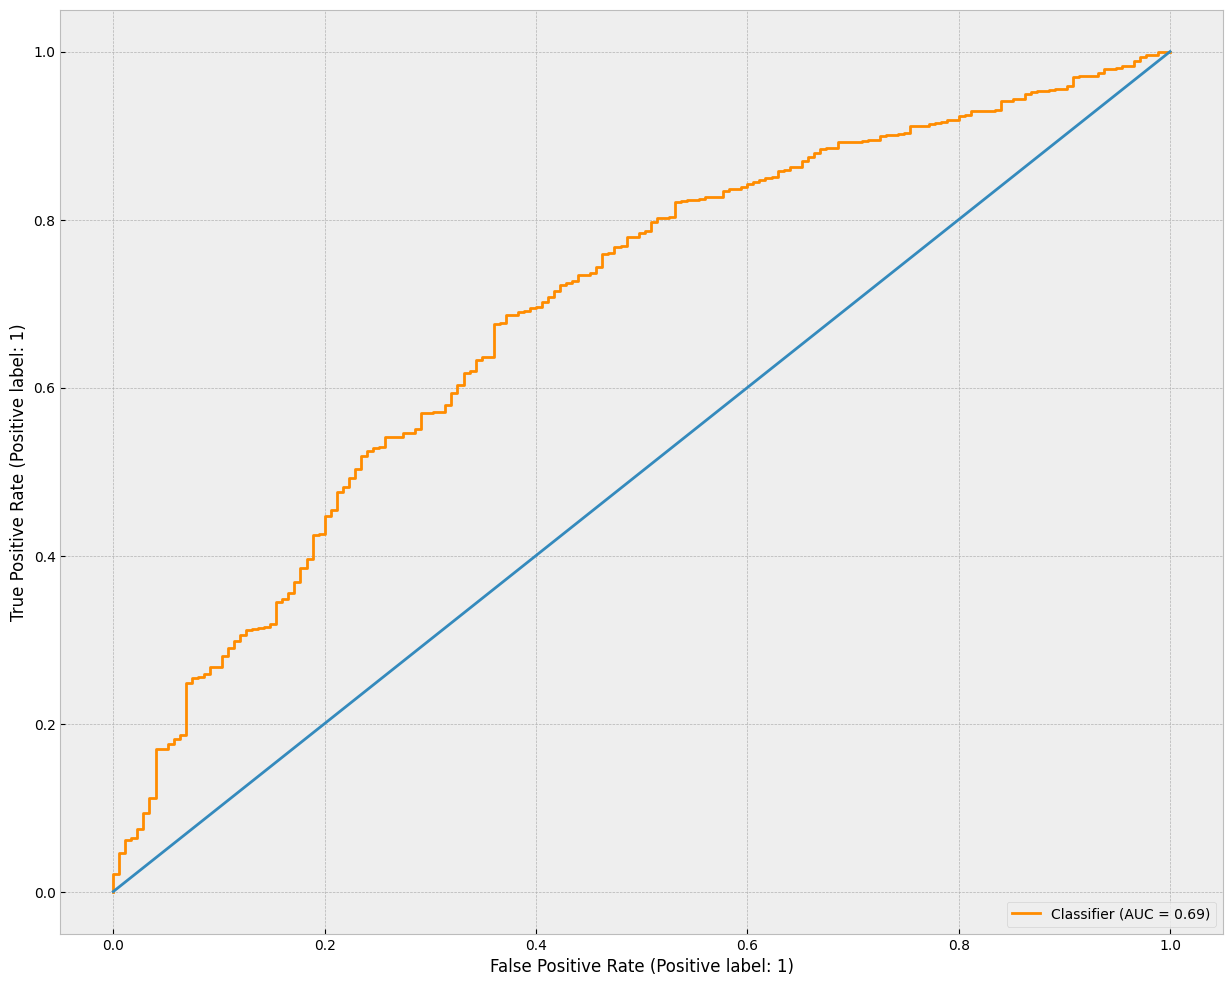

In [283]:
MLEdetector_pruthi = make_detector(embeddings['train'], dict_train_test["train"]["label"], estimation_type = "MLE", kernel = "rbf")
MLEresult_pruthi = MLEdetector_pruthi(embeddings['test'])

MLEscore_pruthi = return_metrics(MLEresult_pruthi, 1 - dict_train_test["test"]["label"], 0.1)

print(f"Score avec l'attaque pruthi de la méthode MLE {MLEscore_pruthi}")

plt.style.use('bmh')
fig,ax = plt.subplots(figsize = (15, 12))

RocCurveDisplay.from_predictions(
    1 - dict_train_test["test"]["label"],
    MLEresult_pruthi,
    color="darkorange",
    ax = ax
)
ax.plot(np.linspace(0,1,10),np.linspace(0,1,10))
plt.show()

Progression ::   0%|          | 0/2 [00:00<?, ?it/s]

Score avec l'attaque pruthi de la méthode RDE {'auc': 0.8914, 'f1': 0.9195402298850576, 'tpr': 0.777}


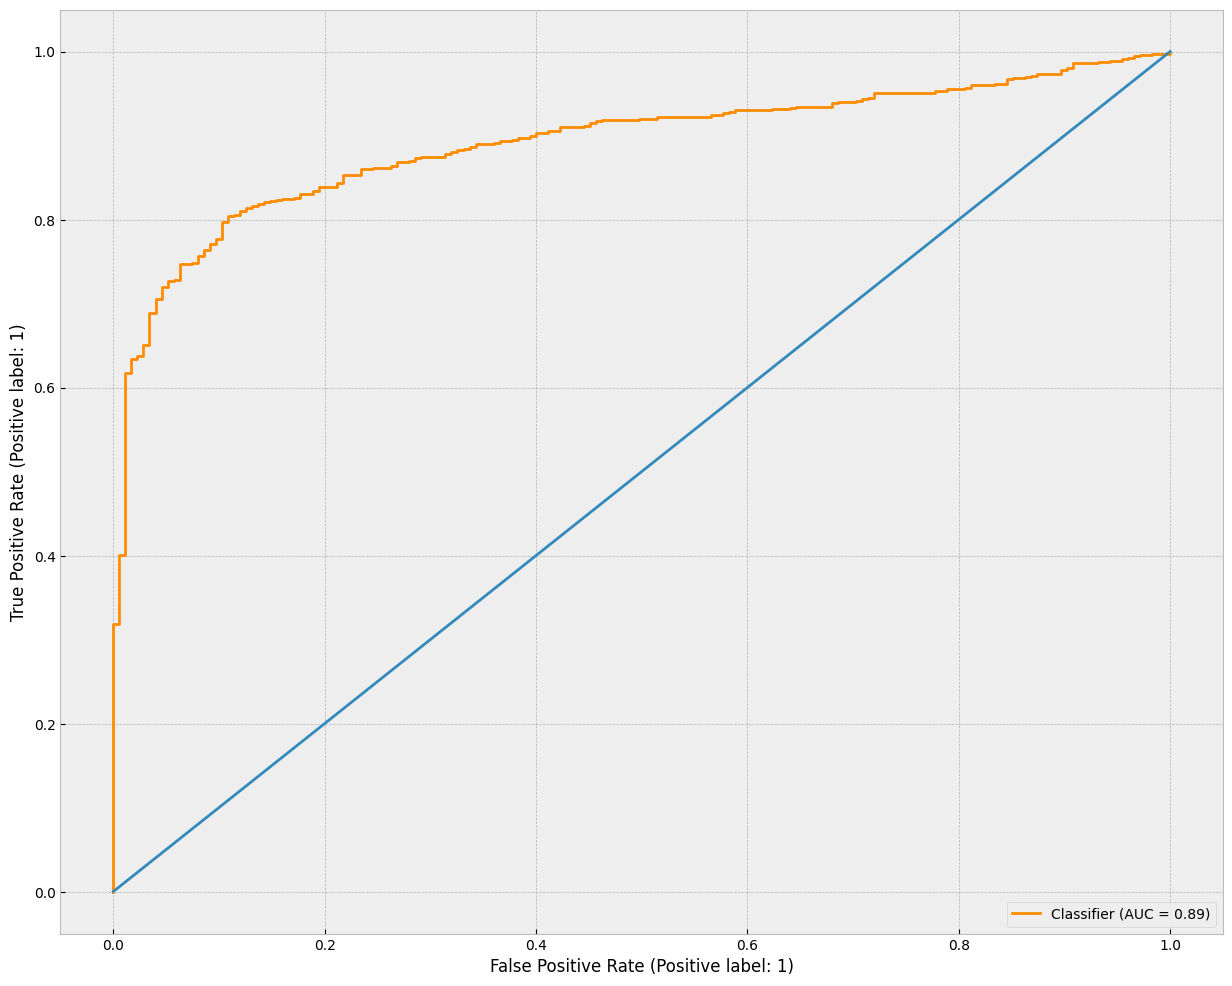

In [284]:
RDEdetector_pruthi = make_detector(embeddings['train'], dict_train_test["train"]["label"], estimation_type = "RDE", kernel = "rbf")
RDEresult_pruthi = RDEdetector_pruthi(embeddings['test'])

RDEscore_pruthi = return_metrics(RDEresult_pruthi, 1 - dict_train_test["test"]["label"], 0.1)

print(f"Score avec l'attaque pruthi de la méthode RDE {RDEscore_pruthi}")

fig,ax = plt.subplots(figsize = (15, 12))

RocCurveDisplay.from_predictions(
    1 - dict_train_test["test"]["label"],
    RDEresult_pruthi,
    color="darkorange",
    ax = ax
)
ax.plot(np.linspace(0,1,10),np.linspace(0,1,10))

plt.show()

In [307]:
dict_train_test = make_train_test("imdb", "bert-base-uncased", "pwws", number_attack_sample = 1000)
embeddings = get_embeddings("textattack/bert-base-uncased-imdb", dict_train_test)

No sentence-transformers model found with name /home/onyxia/.cache/torch/sentence_transformers/textattack_bert-base-uncased-imdb. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/onyxia/.cache/torch/sentence_transformers/textattack_bert-base-uncased-imdb were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progression ::   0%|          | 0/2 [00:00<?, ?it/s]

Score avec l'attaque pwws de la méthode MLE {'auc': 0.6096321585903084, 'f1': 0.22146507666098808, 'tpr': 0.19}


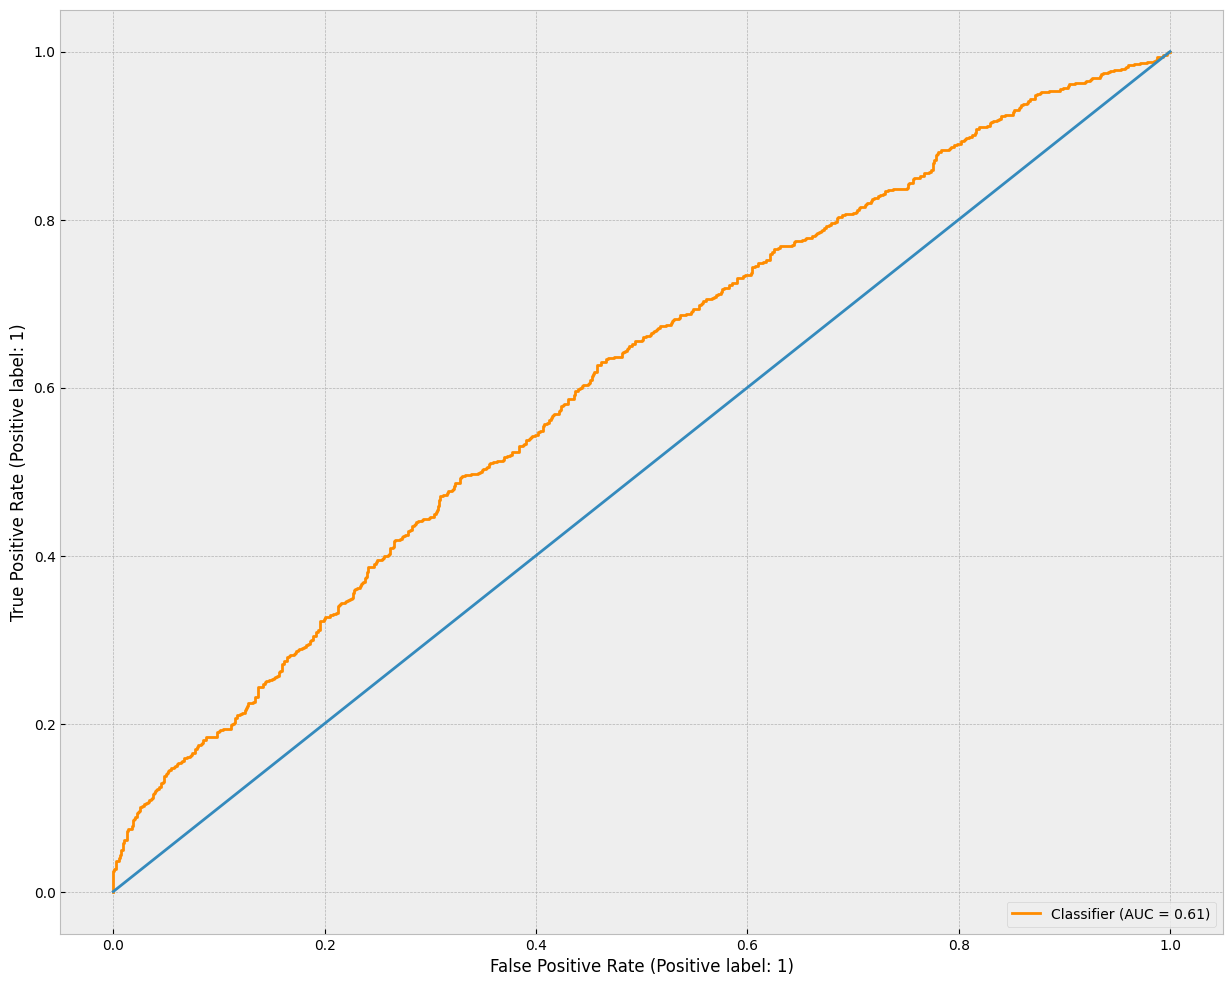

In [286]:
MLEdetector_pwws = make_detector(embeddings['train'], dict_train_test["train"]["label"], estimation_type = "MLE", kernel = "rbf")
MLEresult_pwws = MLEdetector_pwws(embeddings['test'])

MLEscore_pwws = return_metrics(MLEresult_pwws, 1 - dict_train_test["test"]["label"], 0.1)

print(f"Score avec l'attaque pwws de la méthode MLE {MLEscore_pwws}")

plt.style.use('bmh')
fig,ax = plt.subplots(figsize = (15, 12))

RocCurveDisplay.from_predictions(
    1 - dict_train_test["test"]["label"],
    MLEresult_pwws,
    color="darkorange",
    ax = ax
)
ax.plot(np.linspace(0,1,10),np.linspace(0,1,10))
plt.show()

Progression ::   0%|          | 0/2 [00:00<?, ?it/s]

Score avec l'attaque pwws de la méthode RDE {'auc': 0.868556161395856, 'f1': 0.6856359273225917, 'tpr': 0.764}


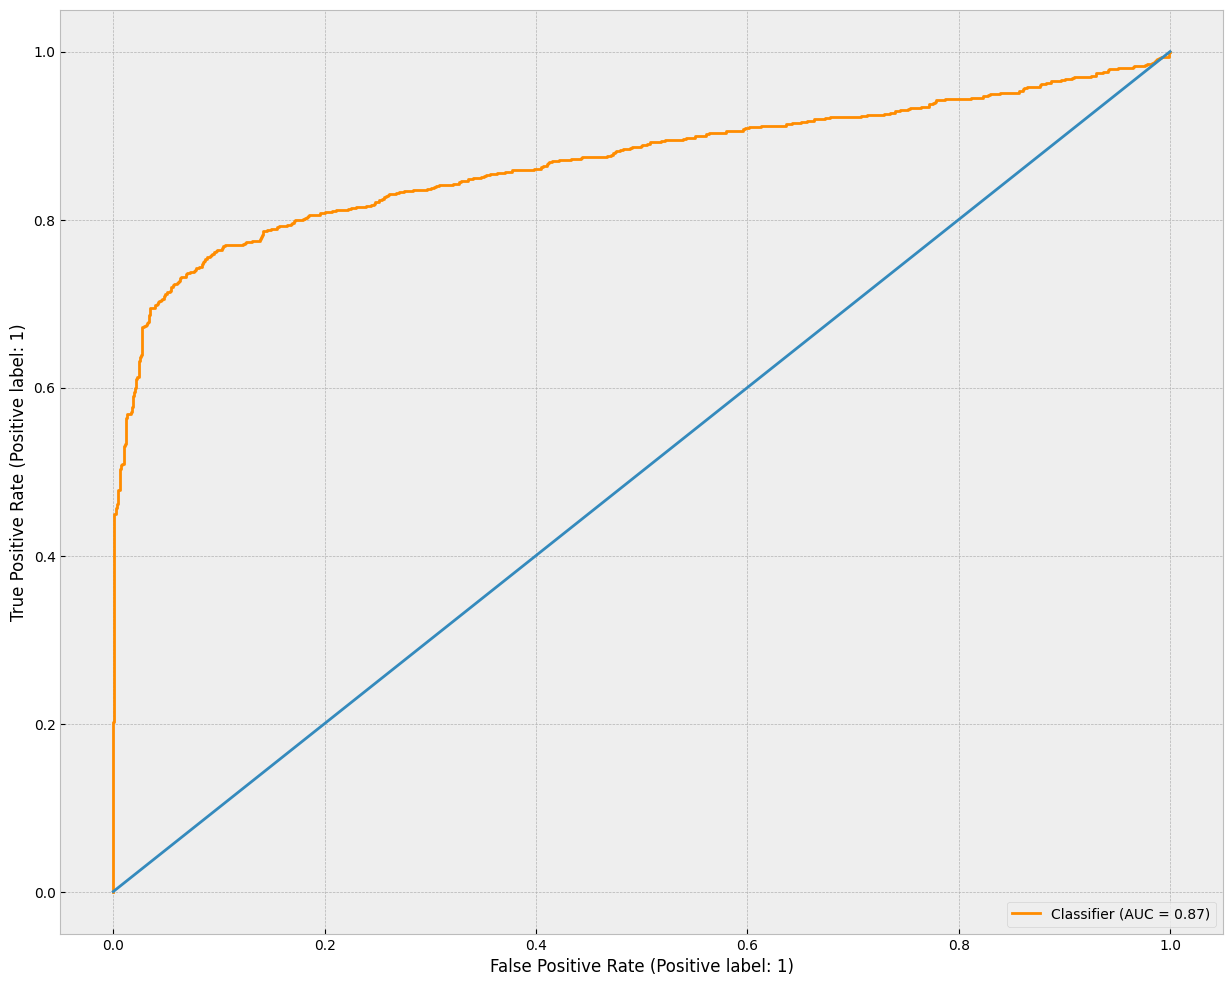

In [308]:
RDEdetector_pwws = make_detector(embeddings['train'], dict_train_test["train"]["label"], estimation_type = "RDE", kernel = "rbf")
RDEresult_pwws = RDEdetector_pwws(embeddings['test'])

RDEscore_pwws = return_metrics(RDEresult_pwws, 1 - dict_train_test["test"]["label"], 0.1)

print(f"Score avec l'attaque pwws de la méthode RDE {RDEscore_pwws}")

plt.style.use('bmh')
fig,ax = plt.subplots(figsize = (15, 12))

RocCurveDisplay.from_predictions(
    1 - dict_train_test["test"]["label"],
    RDEresult_pwws,
    color="darkorange",
    ax = ax
)
ax.plot(np.linspace(0,1,10),np.linspace(0,1,10))
plt.show()

In [309]:
dict_train_test = make_train_test("imdb", "bert-base-uncased", "textfooler", number_attack_sample = 1000)
embeddings = get_embeddings("textattack/bert-base-uncased-imdb", dict_train_test)

No sentence-transformers model found with name /home/onyxia/.cache/torch/sentence_transformers/textattack_bert-base-uncased-imdb. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/onyxia/.cache/torch/sentence_transformers/textattack_bert-base-uncased-imdb were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progression ::   0%|          | 0/2 [00:00<?, ?it/s]

Score avec l'attaque pwws de la méthode MLE {'auc': 0.6211434689507496, 'f1': 0.19516407599309155, 'tpr': 0.207}


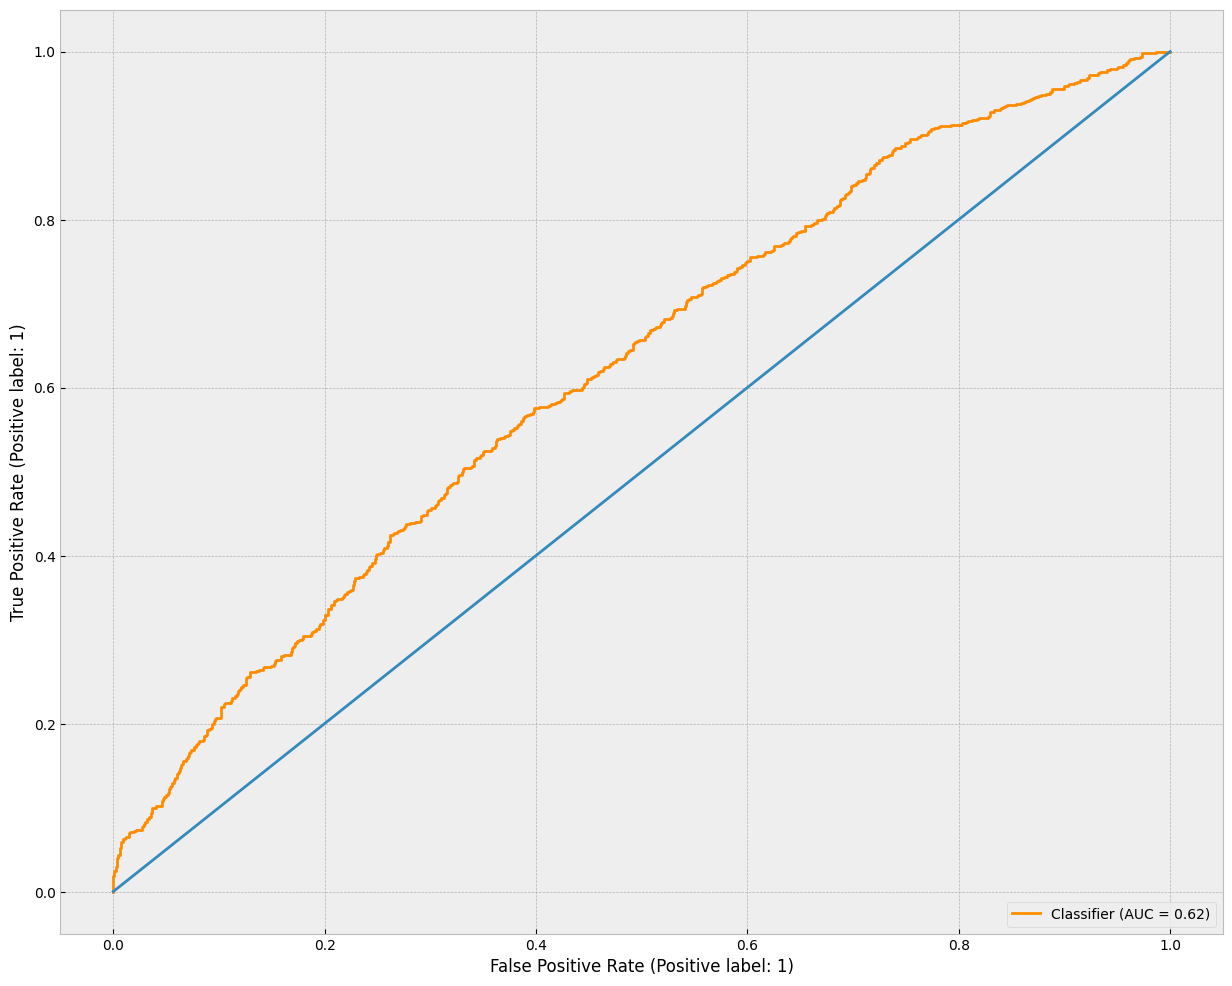

In [290]:
MLEdetector_textfooler = make_detector(embeddings['train'], dict_train_test["train"]["label"], estimation_type = "MLE", kernel = "rbf")
MLEresult_textfooler = MLEdetector_textfooler(embeddings['test'])

MLEscore_textfooler = return_metrics(MLEresult_textfooler, 1 - dict_train_test["test"]["label"], 0.1)

print(f"Score avec l'attaque pwws de la méthode MLE {MLEscore_textfooler}")

plt.style.use('bmh')
fig,ax = plt.subplots(figsize = (15, 12))

RocCurveDisplay.from_predictions(
    1 - dict_train_test["test"]["label"],
    MLEresult_textfooler,
    color="darkorange",
    ax = ax
)
ax.plot(np.linspace(0,1,10),np.linspace(0,1,10))
plt.show()

Progression ::   0%|          | 0/2 [00:00<?, ?it/s]

Score avec l'attaque textfooler de la méthode RDE {'auc': 0.9005547045951859, 'f1': 0.6863417982155113, 'tpr': 0.805}


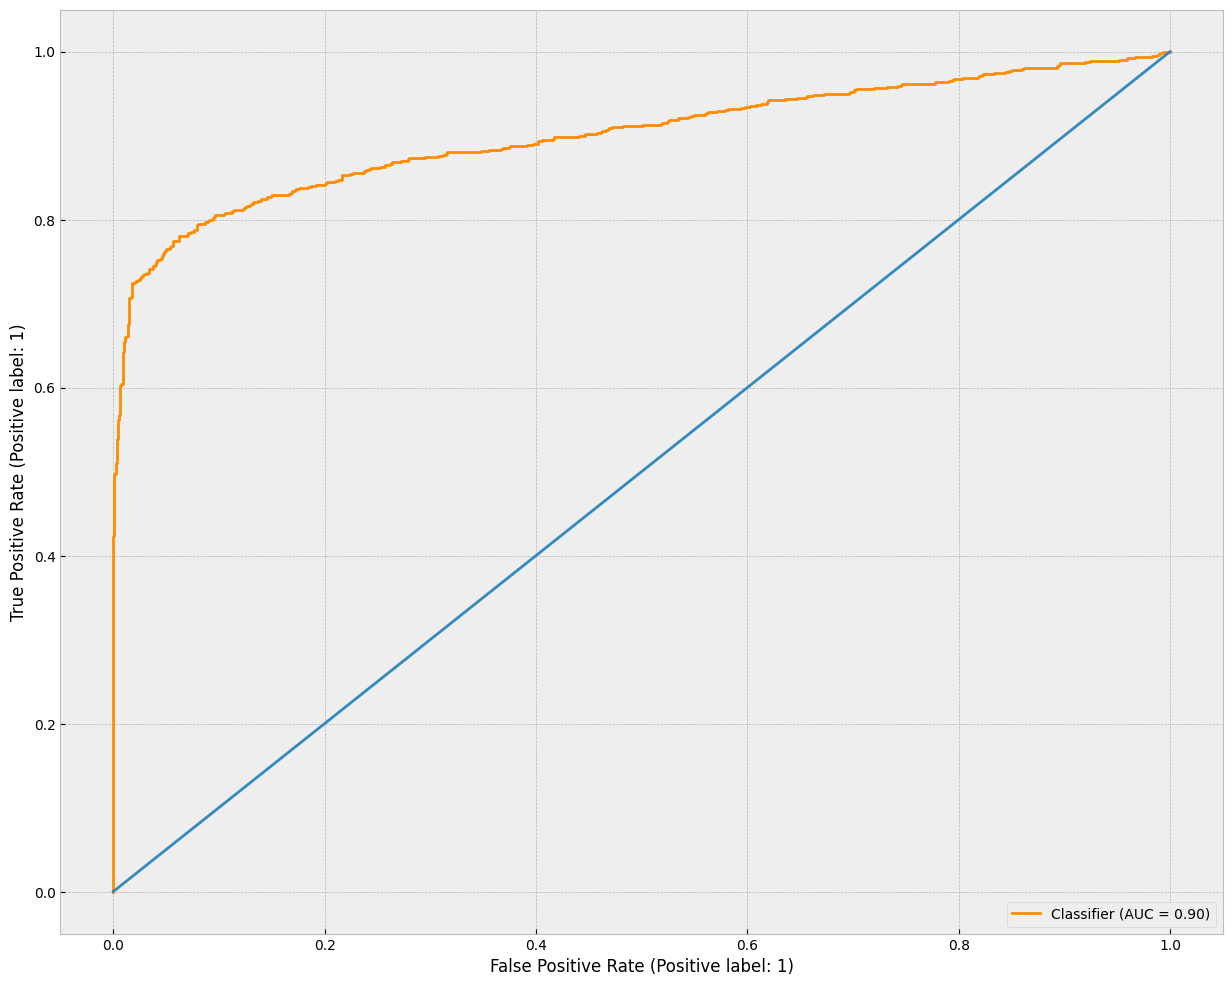

In [310]:
RDEdetector_textfooler = make_detector(embeddings['train'], dict_train_test["train"]["label"], estimation_type = "RDE", kernel = "rbf")
RDEresult_textfooler = RDEdetector_textfooler(embeddings['test'])

RDEscore_textfooler = return_metrics(RDEresult_textfooler, 1 - dict_train_test["test"]["label"], 0.1)

print(f"Score avec l'attaque textfooler de la méthode RDE {RDEscore_textfooler}")

plt.style.use('bmh')
fig,ax = plt.subplots(figsize = (15, 12))

RocCurveDisplay.from_predictions(
    1 - dict_train_test["test"]["label"],
    RDEresult_textfooler,
    color="darkorange",
    ax = ax
)
ax.plot(np.linspace(0,1,10),np.linspace(0,1,10))
plt.show()

In [311]:
dict_train_test = make_train_test("imdb", "bert-base-uncased", "tf-adj", number_attack_sample = 1000)
embeddings = get_embeddings("textattack/bert-base-uncased-imdb", dict_train_test)

No sentence-transformers model found with name /home/onyxia/.cache/torch/sentence_transformers/textattack_bert-base-uncased-imdb. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/onyxia/.cache/torch/sentence_transformers/textattack_bert-base-uncased-imdb were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progression ::   0%|          | 0/2 [00:00<?, ?it/s]

Score avec l'attaque tf-adj de la méthode MLE {'auc': 0.7463591549295775, 'f1': 0.2168888888888889, 'tpr': 0.35}


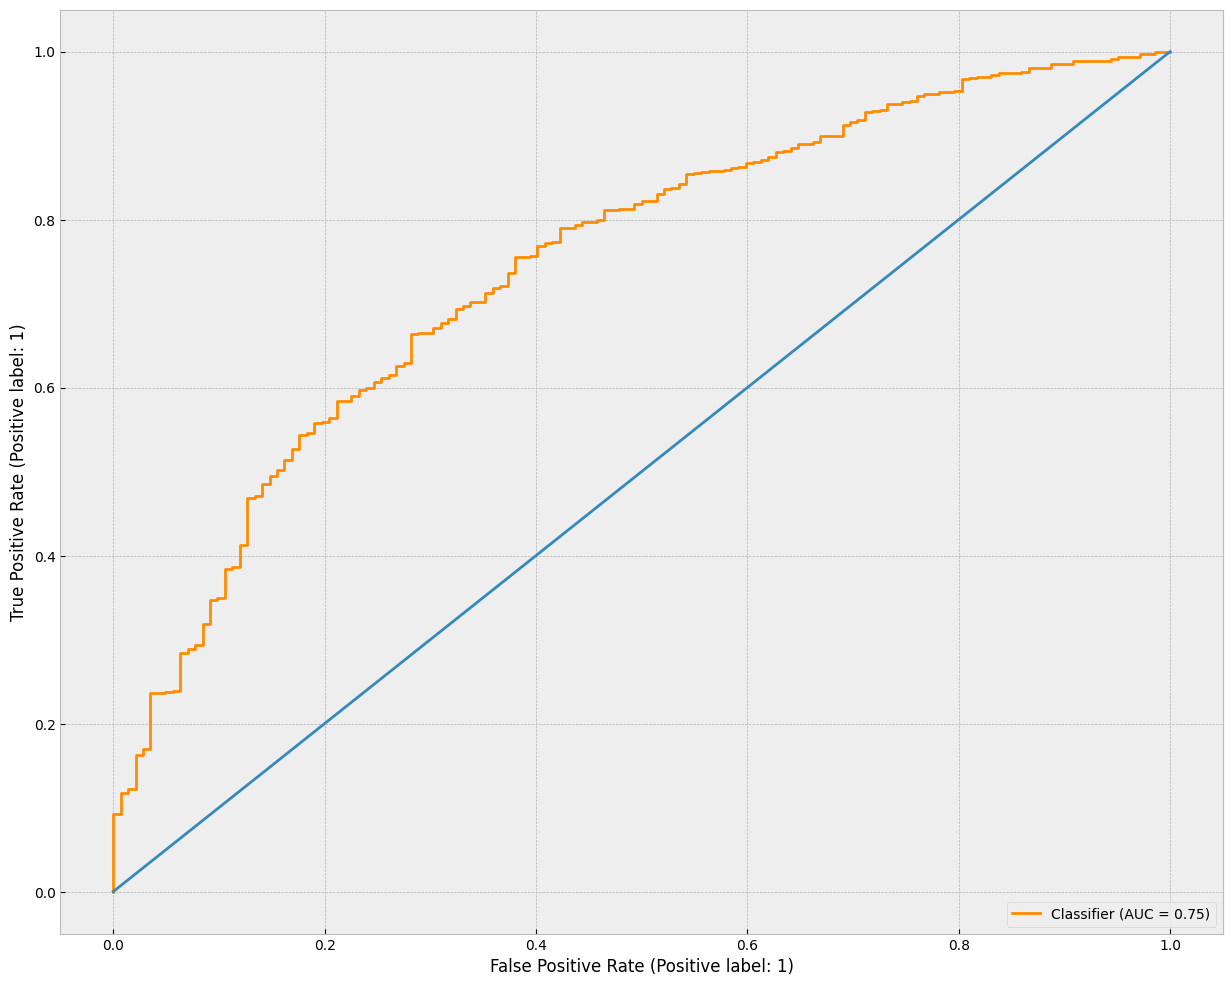

In [293]:
MLEdetector_tf_adj = make_detector(embeddings['train'], dict_train_test["train"]["label"], estimation_type = "MLE", kernel = "rbf")
MLEresult_tf_adj = MLEdetector_tf_adj(embeddings['test'])

MLEscore_tf_adj = return_metrics(MLEresult_tf_adj, 1 - dict_train_test["test"]["label"], 0.1)

print(f"Score avec l'attaque tf-adj de la méthode MLE {MLEscore_tf_adj}")

plt.style.use('bmh')
fig,ax = plt.subplots(figsize = (15, 12))

RocCurveDisplay.from_predictions(
    1 - dict_train_test["test"]["label"],
    MLEresult_tf_adj,
    color="darkorange",
    ax = ax
)
ax.plot(np.linspace(0,1,10),np.linspace(0,1,10))
plt.show()

Progression ::   0%|          | 0/2 [00:00<?, ?it/s]

Score avec l'attaque pwws de la méthode RDE {'auc': 0.9073503184713376, 'f1': 0.9272137227630969, 'tpr': 0.806}


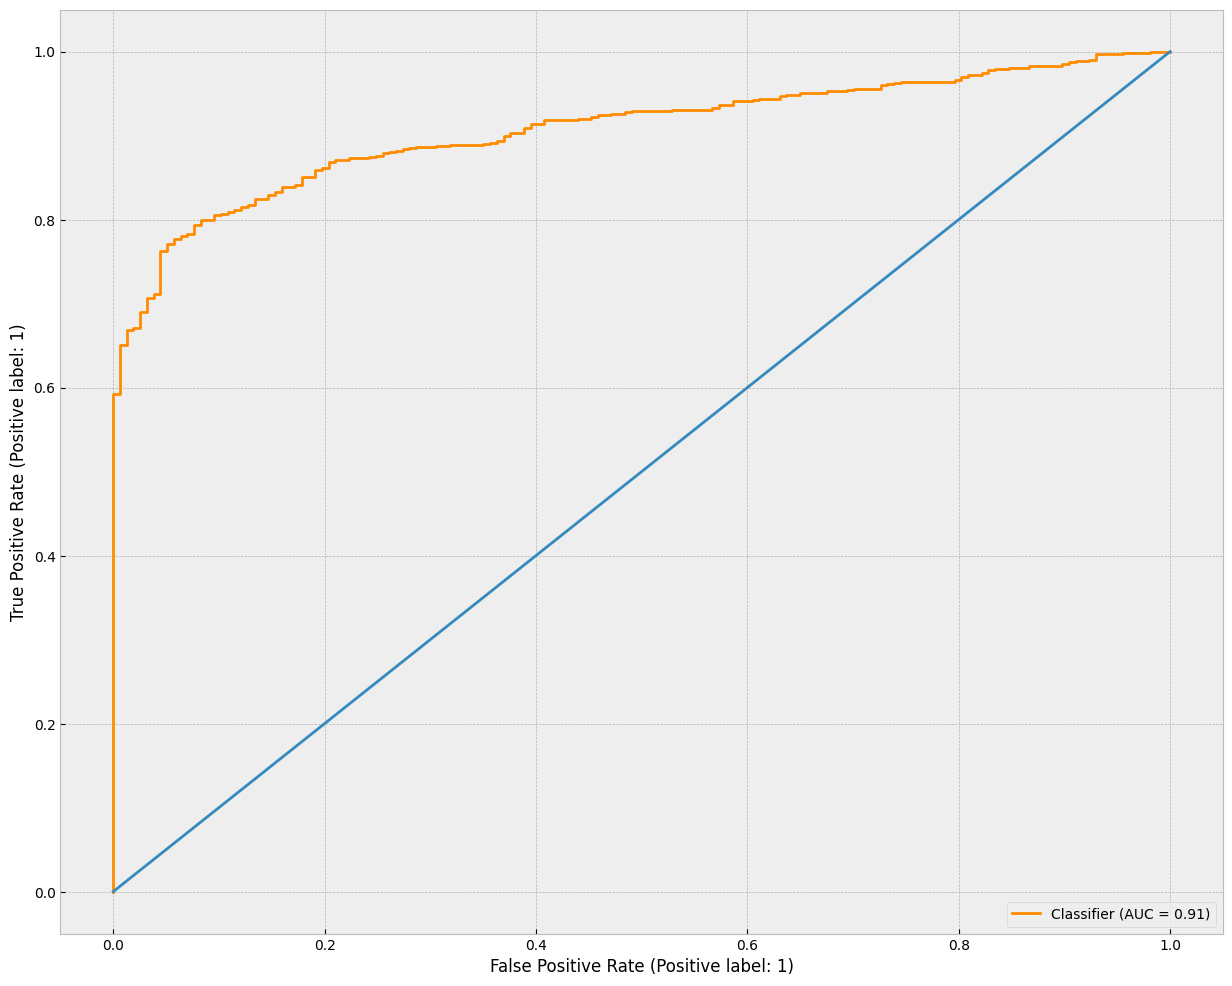

In [312]:
RDEdetector_tf_adj = make_detector(embeddings['train'], dict_train_test["train"]["label"], estimation_type = "RDE", kernel = "rbf")
RDEresult_tf_adj = RDEdetector_tf_adj(embeddings['test'])

RDEscore_tf_adj = return_metrics(RDEresult_tf_adj, 1 - dict_train_test["test"]["label"], 0.1)

print(f"Score avec l'attaque pwws de la méthode RDE {RDEscore_tf_adj}")

plt.style.use('bmh')
fig,ax = plt.subplots(figsize = (15, 12))

RocCurveDisplay.from_predictions(
    1 - dict_train_test["test"]["label"],
    RDEresult_tf_adj,
    color="darkorange",
    ax = ax
)
ax.plot(np.linspace(0,1,10),np.linspace(0,1,10))
plt.show()

## With simple PCA : 

In [ ]:
# What would happen if we do a simple PCA ? 
#Instantiate PCA : 
PCA = Decomposition.PCA(n_components = 100)
embeddings_PCA = PCA.fit_transform(IMDB_embeddings)

#interlude : separation of class 0 and 1 : 
class_1_IMDB = embeddings_PCA[imdb_dataset["ground_truth_output"] == 1]
class_0_IMDB = embeddings_PCA[imdb_dataset["ground_truth_output"] == 0]

#Now the MLE estimation after PCA : 
MLE_mean1 = np.sum(class_1_IMDB, axis=0)/np.shape(class_0_IMDB)[0]
MLE_mean0 = np.sum(class_0_IMDB, axis=0)/np.shape(class_0_IMDB)[0]

#For covariance we make a loop :
MLE_cov1 = np.zeros((MLE_mean1.shape[0],MLE_mean1.shape[0])) 
MLE_cov0 = np.zeros((MLE_mean0.shape[0],MLE_mean0.shape[0])) 
for line in class_1_IMDB : 
    MLE_cov1 = MLE_cov1 + np.reshape(line,(line.shape[0],1))@np.reshape(line,(1,line.shape[0]))

for line in class_0_IMDB : 
    MLE_cov0 = MLE_cov0 + np.reshape(line,(line.shape[0],1))@np.reshape(line,(1,line.shape[0]))

In [ ]:
#Now we can add the MCD :
MCD_cov1 = Covariance.MinCovDet()
MCD_cov1.fit(embeddings_PCA[imdb_dataset["ground_truth_output"] == 1])

RDE_mean1 = MCD_cov1.location_
RDE_cov1 = MCD_cov1.covariance_

MCD_cov0 = Covariance.MinCovDet()
MCD_cov0.fit(embeddings_PCA[imdb_dataset["ground_truth_output"] == 0])

RDE_mean0 = MCD_cov0.location_
RDE_cov0 = MCD_cov0.covariance_

In [ ]:
#Let's try to visualise the distribution, with the MLE : 

#To have the value of 2d multivariate at different point (made to be used with np.meshgrid) 
normal_density_1 = multivariate_normal(MLE_mean1[0:2], MLE_cov1[0:2,0:2])
normal_density_0 = multivariate_normal(MLE_mean0[0:2], MLE_cov0[0:2,0:2])

plt.style.use('bmh')
fig,ax = plt.subplots(figsize = (15, 15))

abscisse, ordonnee = np.meshgrid(np.linspace(-100, 100, 100), np.linspace(-100, 100, 100))
level = np.dstack((abscisse, ordonnee))

ax.contour(abscisse, ordonnee, normal_density_1.pdf(level), 20, levels = 5, colors = "red")
ax.contour(abscisse, ordonnee, normal_density_0.pdf(level), 20, levels = 5, colors = "blue")

ax.set_xlim((-100,100))
ax.set_ylim((-100,100))

plt.show()

In [ ]:
#Let's try to visualise the distribution, with the RDE : 

#To have the value of 2d multivariate at different point (made to be used with np.meshgrid) 
normal_density_1 = multivariate_normal(RDE_mean1[0:2], RDE_cov1[0:2,0:2])
normal_density_0 = multivariate_normal(RDE_mean0[0:2], RDE_cov0[0:2,0:2])

plt.style.use('bmh')
fig,ax = plt.subplots(figsize = (15, 15))

abscisse, ordonnee = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
level = np.dstack((abscisse, ordonnee))

ax.contour(abscisse, ordonnee, normal_density_1.pdf(level), 20, levels = 5, colors = "red")
ax.contour(abscisse, ordonnee, normal_density_0.pdf(level), 20, levels = 5, colors = "blue")

ax.set_xlim((-10,10))
ax.set_ylim((-10,10))

plt.show()

In [ ]:
#Let's try to visualise the value of the density for different point, with the RDE : 

#To have the value of 2d multivariate at different point :
normal_density_0 = multivariate_normal(RDE_mean0, RDE_cov0)

fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (15, 7))

ax1.scatter(class_0_IMDB[:,0], class_0_IMDB[:,1], c = np.log(normal_density_0.pdf(class_0_IMDB)))

print(np.log(normal_density_0.pdf(class_0_IMDB)))

ax1.set_title("Density with RDE")

normal_density_0 = multivariate_normal(MLE_mean0, MLE_cov0)

ax2.scatter(class_0_IMDB[:,0], class_0_IMDB[:,1], c = np.log(normal_density_0.pdf(class_0_IMDB)))

ax2.set_ylim((-10,10))
ax2.set_title("Density with MLE")

plt.show()

In [121]:
#Now with the adversarial examples : 

imdb_sentences = imdb_dataset["perturbed_text"].apply(lambda x : x.replace("[","").replace("]",""))

#Let"s get the embedding : 
perturbed_IMDB_embeddings = BERT_transformer.encode(imdb_sentences)

perturbed_0 = PCA.transform(perturbed_IMDB_embeddings[imdb_dataset["perturbed_output"] == 0])
perturbed_1 = PCA.transform(perturbed_IMDB_embeddings[imdb_dataset["perturbed_output"] == 1])


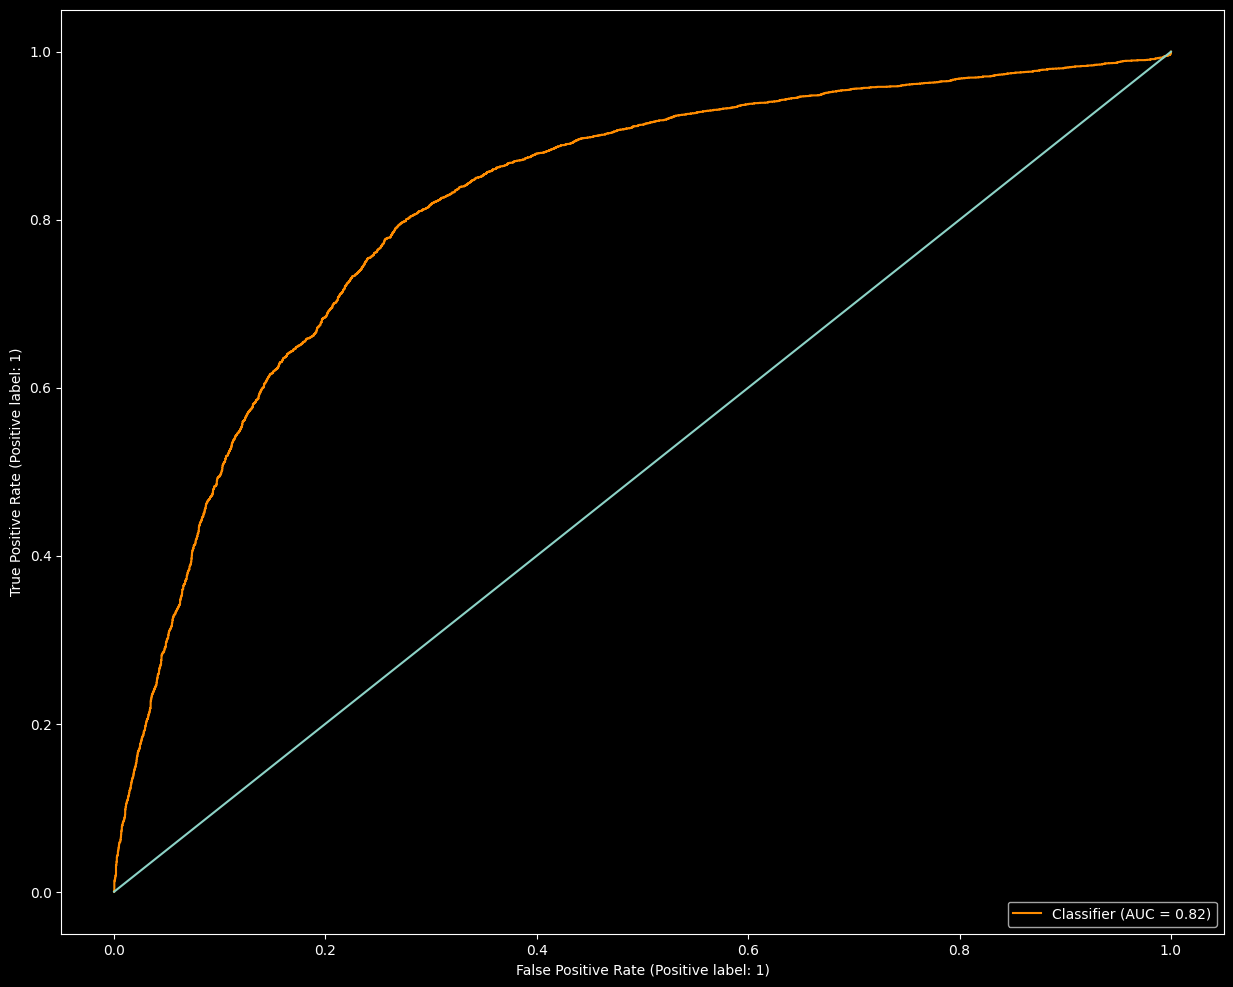

In [122]:
#Let's see the ROC curve for the RDE estimation : 

from sklearn.metrics import roc_curve,RocCurveDisplay

normal_density_0 = multivariate_normal(RDE_mean0, RDE_cov0)

score_perturbed = normal_density_0.logpdf(perturbed_0)
score_normal = normal_density_0.logpdf(class_0_IMDB)
total_score = np.concatenate((score_perturbed,score_normal))
label = np.concatenate((np.zeros(score_perturbed.shape[0]),np.ones(score_normal.shape[0])))

fig,ax = plt.subplots(figsize = (15, 12))

RocCurveDisplay.from_predictions(
    label,
    total_score,
    color="darkorange",
    ax = ax
)
ax.plot(np.linspace(0,1,10),np.linspace(0,1,10))

plt.show()